TODO:
* Feature Engeeniring
* Find model
* Train model

ADDITIONS:
* Create new features if needed

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

#disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
df = pd.read_csv('data/apollo-accounts-export.csv')

#drop useless cols and convert cols names to useful form convenient
df.columns = df.columns.str.lower().str.replace(' ', '_')
dc = ['company','company_name_for_emails', 'account_stage', 'lists', 'account_owner', 'website', 'company_linkedin_url',
     'facebook_url', 'logo_url','apollo_account_id', 'twitter_url', 'company_phone', 'company_street', 'company_postal_code', 'sic_codes', 'seo_description']
df.drop(dc, axis=1, inplace=True)
df.dropna(subset=['annual_revenue'],axis=0, inplace=True)
df.head(3)

,#_employees,industry,company_city,company_state,company_country,company_address,keywords,technologies,total_funding,latest_funding,latest_funding_amount,last_raised_at,annual_revenue,number_of_retail_locations,short_description,founded_year
0,20.00,apparel & fashion,Santarcangelo di Romagna,Emilia-Romagna,Italy,"Santarcangelo di Romagna, Emilia-Romagna, Italy",NaN,"Mailchimp Mandrill, Gmail, Google Apps, Micros...",NaN,Other,NaN,2017-10-01,9000000.00,NaN,Luxury Vintage\n\nMr & Mrs Italy interprets ic...,2007.00
1,3.00,apparel & fashion,Honolulu,Hawaii,United States,"Honolulu, Hawaii, United States","clothing, swimwear, jewelry, beachwear","Gmail, Google Apps, BigCommerce, UPS, Google t...",NaN,NaN,NaN,NaN,4528000.00,NaN,Beach Wahine is a premier beach lifestyle Hawa...,2012.00
2,8.00,apparel & fashion,Los Angeles,California,United States,"Los Angeles, California, United States","children's clothing, fashion, men's clothing, ...","MailChimp SPF, Microsoft Office 365, Mixpanel,...",NaN,NaN,NaN,NaN,13470000.00,1.00,BedHead Pajamas is an online apparel retailer ...,1997.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   #_employees                 48562 non-null  float64
 1   industry                    48338 non-null  object 
 2   company_city                36417 non-null  object 
 3   company_state               38068 non-null  object 
 4   company_country             42324 non-null  object 
 5   company_address             42332 non-null  object 
 6   keywords                    37586 non-null  object 
 7   technologies                46267 non-null  object 
 8   total_funding               3649 non-null   float64
 9   latest_funding              4272 non-null   object 
 10  latest_funding_amount       3468 non-null   float64
 11  last_raised_at              4272 non-null   object 
 12  annual_revenue              48562 non-null  float64
 13  number_of_retail_locations  112

In [4]:
df.last_raised_at = pd.to_datetime(df.last_raised_at)
# convert last_raised_at to numerical in a fly
df.last_raised_at = np.datetime64("2022-01-01") - df.last_raised_at
df.last_raised_at = df.last_raised_at.dt.days

## Feature Engeeniring
TODO:
1. EDA
2. Handling missing values
3. Handling inbalanced with log
4. Treating Outliers ?
5. Scaling the data
6. Converting categorical values
7. Feature selection


### Exploratory Data Analysis

Get and plot all features which have null values

In [5]:
features_with_nulls = [feature for feature in df.columns if df[feature].isnull().sum() > 1]

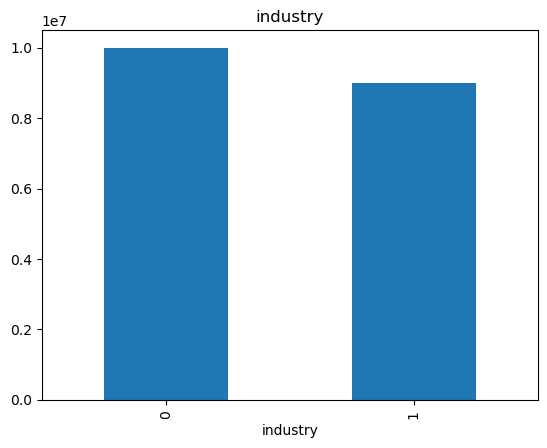

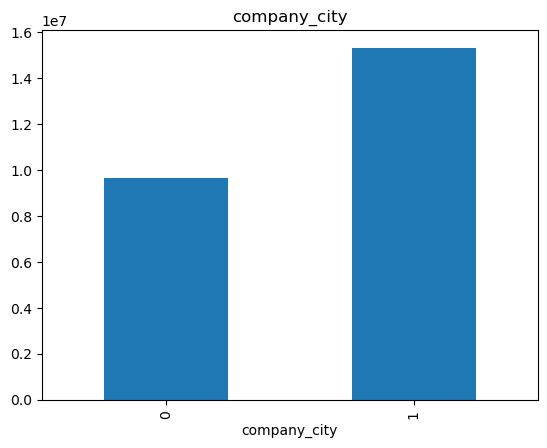

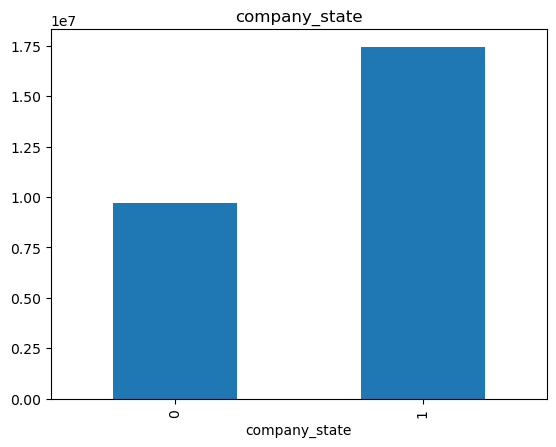

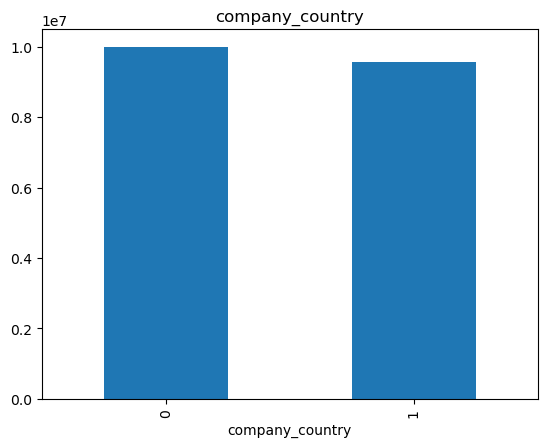

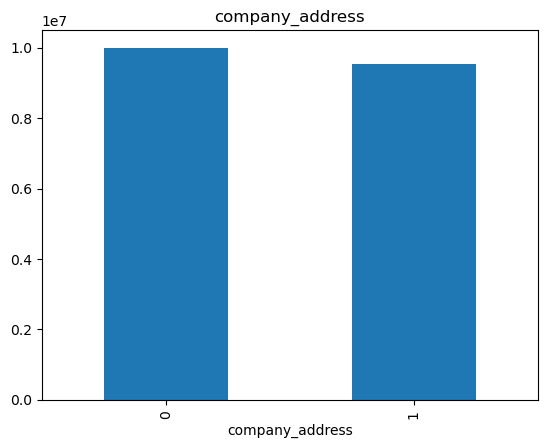

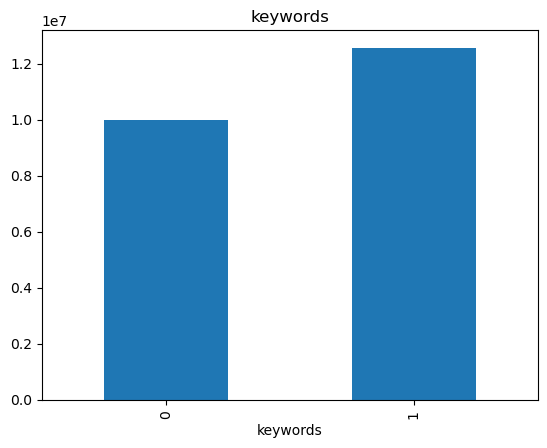

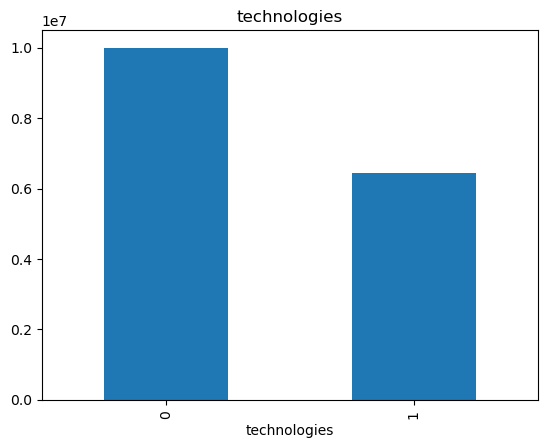

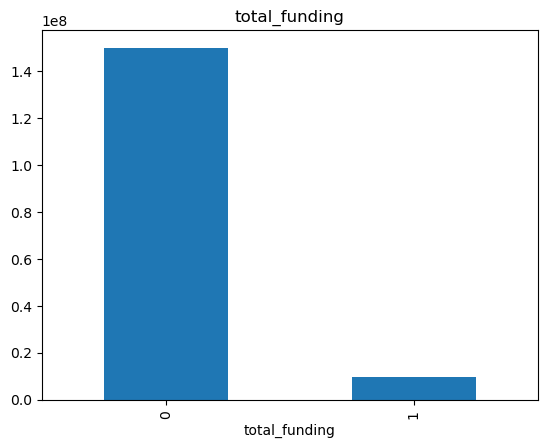

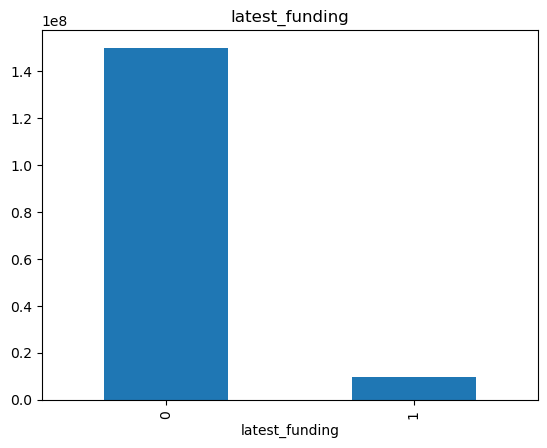

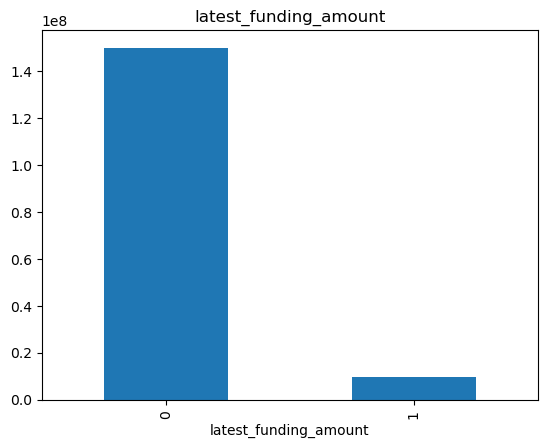

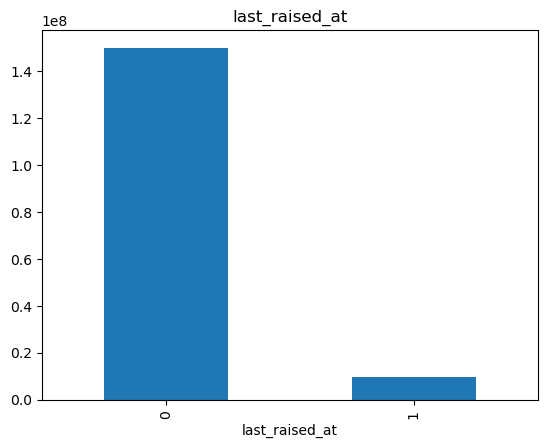

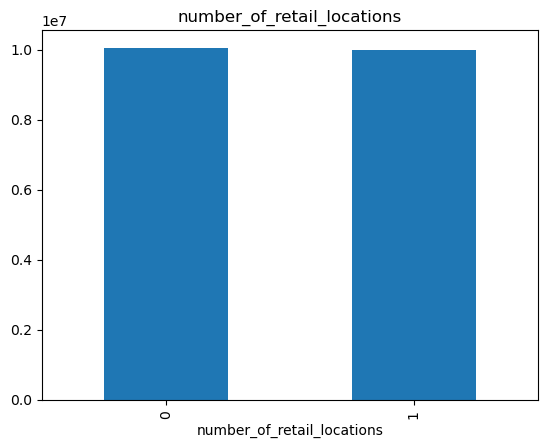

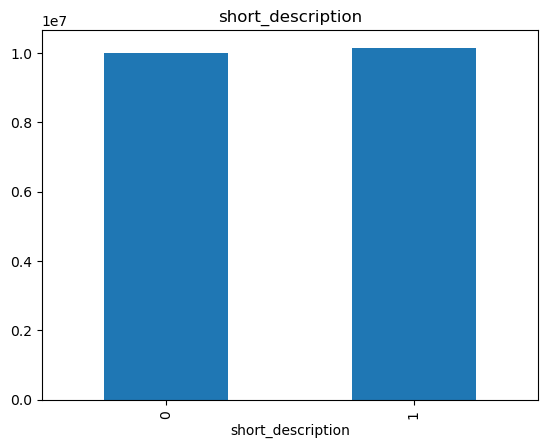

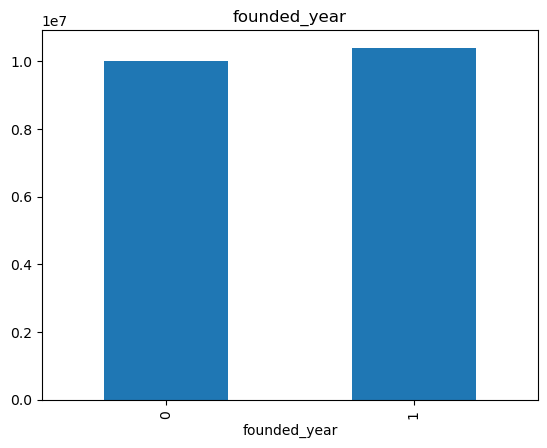

In [6]:
for feature in features_with_nulls:
    data = df.copy()
    
    data[feature] = np.where(data[feature].isnull(),1,0)
    data.groupby(feature)['annual_revenue'].median().plot.bar()
    plt.title(feature)
    plt.show()

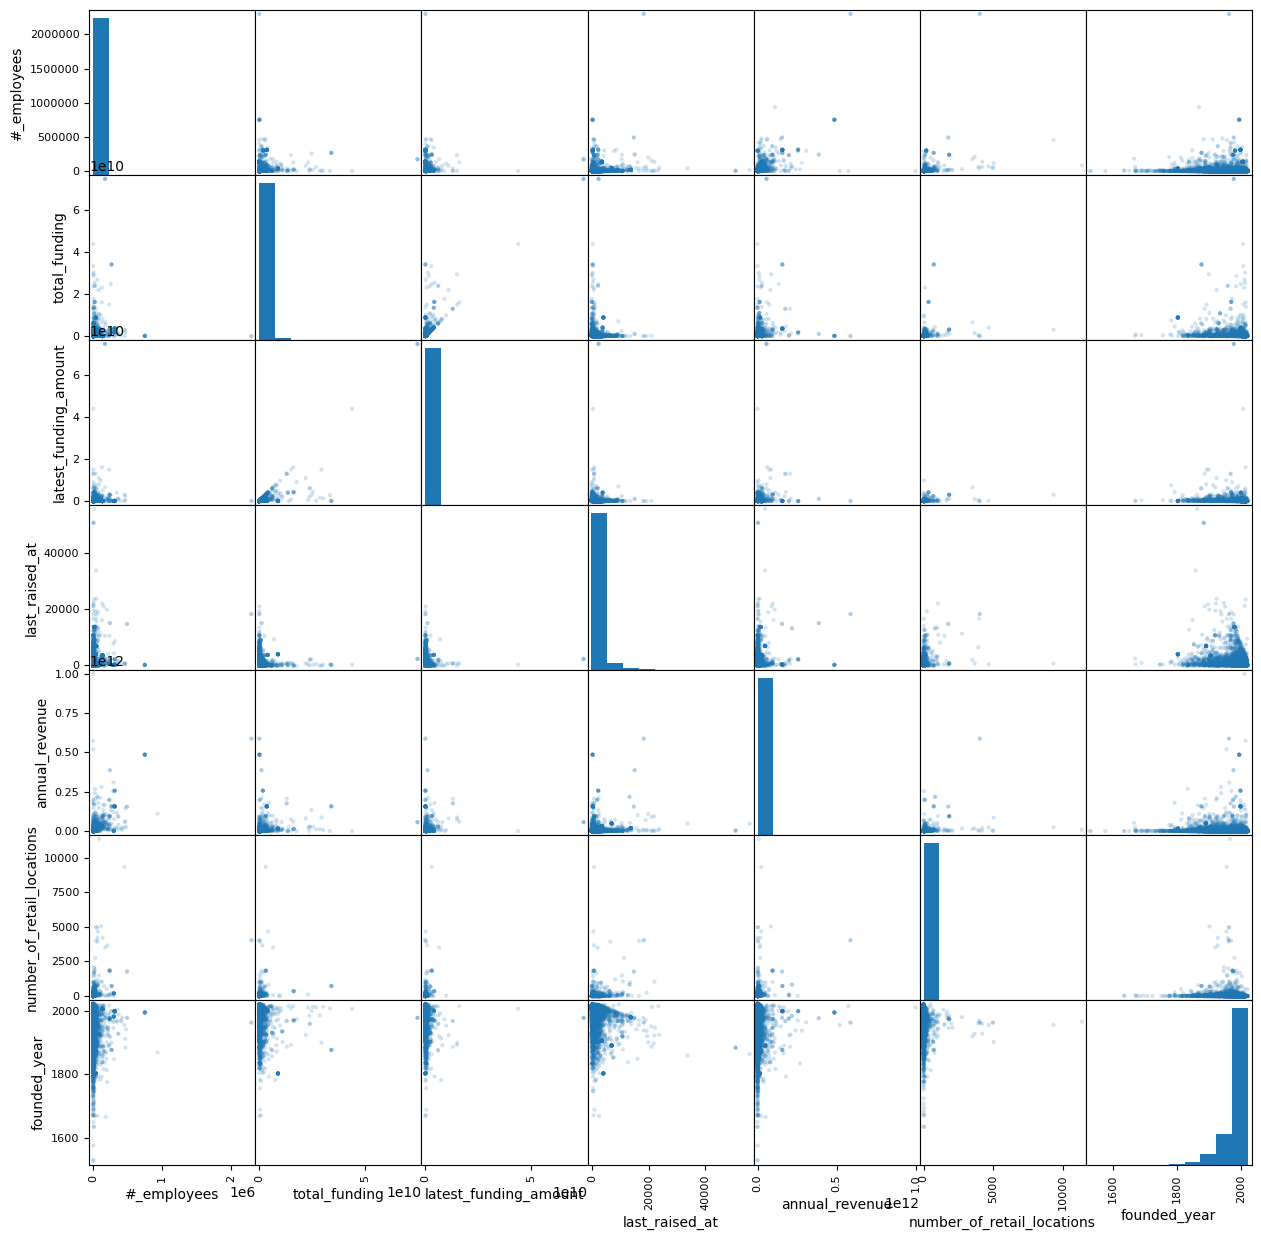

In [7]:
#plot numerica; values
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(15,15));

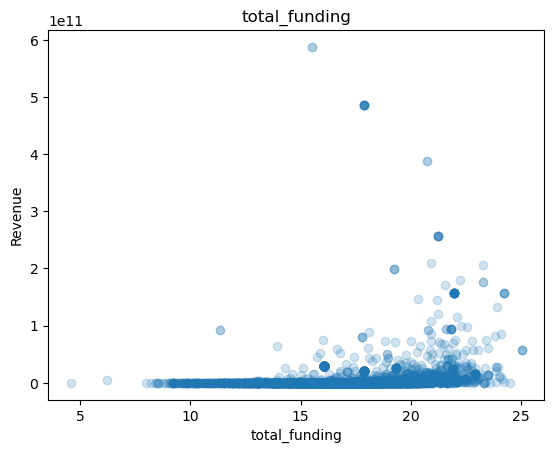

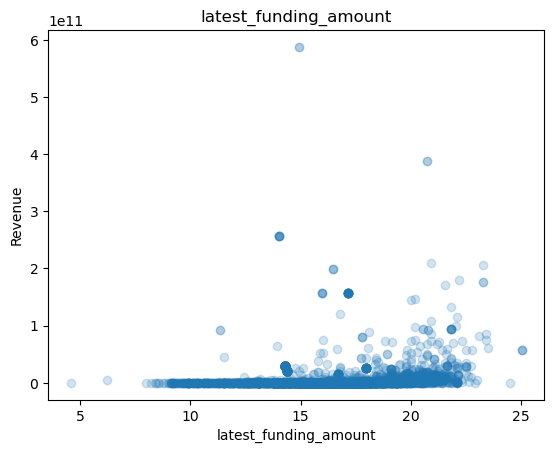

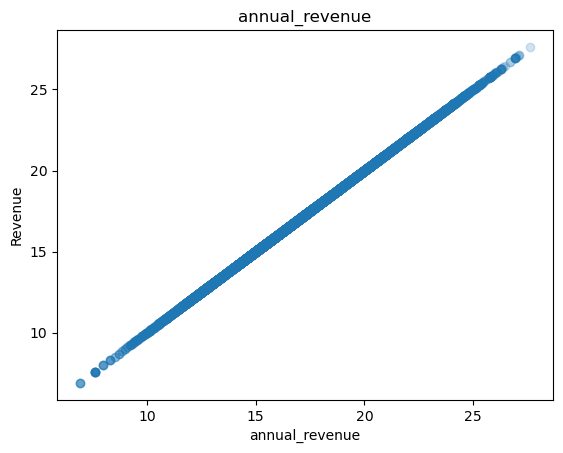

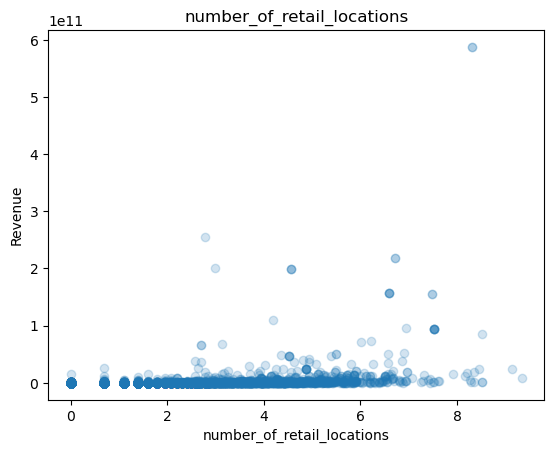

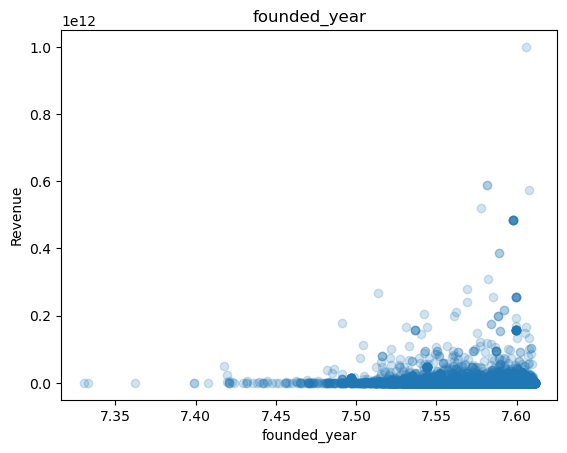

In [8]:
#transoform numeric to log form
numeric_features = [feature for feature in df.columns if df[feature].dtype == 'float64']


for feature in numeric_features:
    data = df.copy()
    
    if 0 in data[feature].unique():
        pass
    else:
        data[feature] = np.log(data[feature])
        plt.scatter(x=data[feature], y=data.annual_revenue, alpha=0.2)
        plt.xlabel(feature)
        plt.ylabel('Revenue')
        plt.title(feature)
        plt.show()


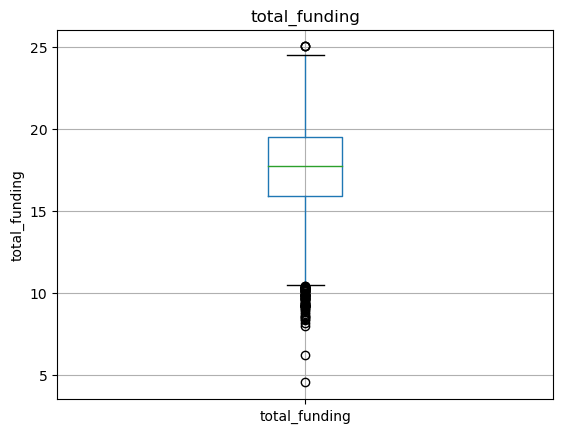

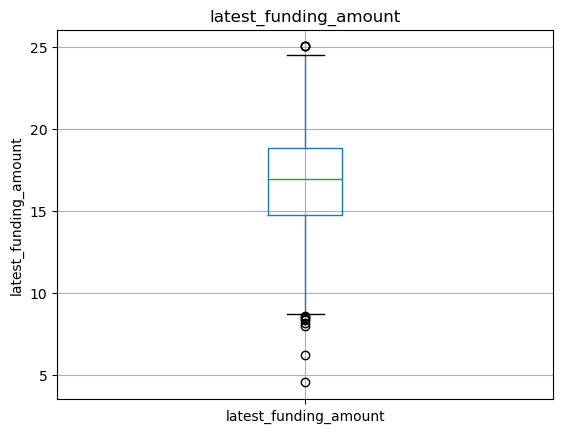

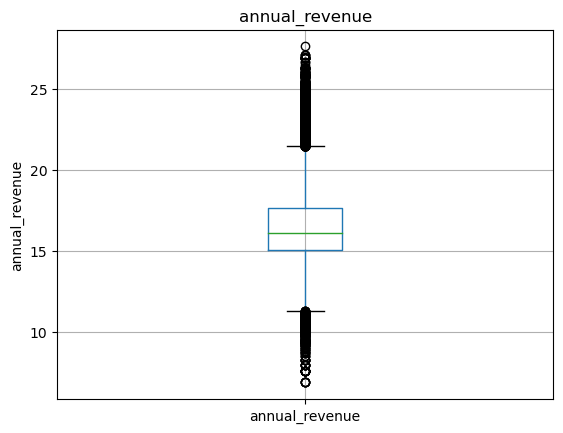

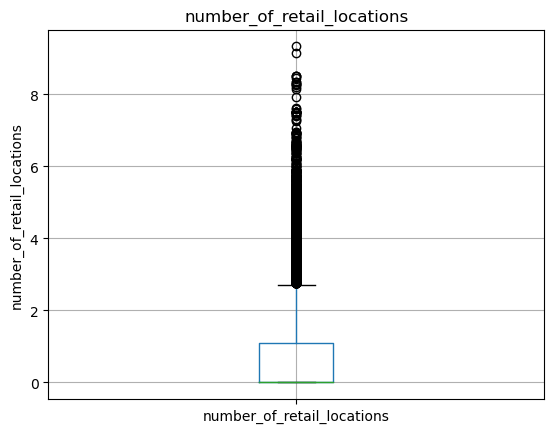

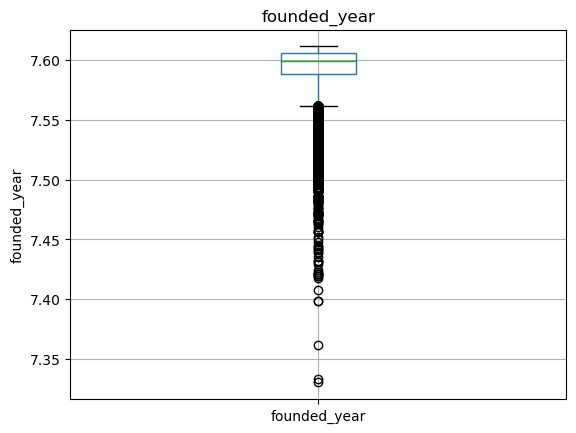

In [9]:
# check outliers
for feature in numeric_features:
    data = df.copy()
    
    if 0 in data[feature].unique():
        pass
    else:
        data[feature] = np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()

In [10]:
# how many unique values in categorical columns
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

df[categorical_features].nunique()

industry               142
company_city          7674
company_state          915
company_country        147
company_address      24743
keywords             30909
technologies         37048
latest_funding          15
short_description    39083
dtype: int64

TODO: Categorical features with plain text will be vectorized

In [11]:
df.groupby(['industry'],as_index=False)\
    .agg({'annual_revenue':'sum'})\
    .sort_values(by='annual_revenue',ascending=False).head(20)

,industry,annual_revenue
62,information technology & services,14547989652000.00
120,retail,8840055220000.00
133,transportation/trucking/railroad,4696653290000.00
5,apparel & fashion,3003907453000.00
35,electrical/electronic manufacturing,2366488449000.00
8,automotive,2085002187000.00
81,mechanical or industrial engineering,1775604559000.00
42,financial services,1229482421000.00
128,telecommunications,1176730958000.00
46,food production,1110636192000.00


### Missing values
* try to get info about country from state or postal code 
* replace categorical with "missing" value
* convert founded_year to how many years from current year
* replace num featurese with median/mean a create attributes with bool is empty


In [12]:
missing_features = [feature for feature in df if df.keywords.isnull().any()]
missing_features

['#_employees',
 'industry',
 'company_city',
 'company_state',
 'company_country',
 'company_address',
 'keywords',
 'technologies',
 'total_funding',
 'latest_funding',
 'latest_funding_amount',
 'last_raised_at',
 'annual_revenue',
 'number_of_retail_locations',
 'short_description',
 'founded_year']

Fill na company_country by company_state

In [13]:
df.loc[(~df.company_state.isna()) & (df.company_country.isna())]

,#_employees,industry,company_city,company_state,company_country,company_address,keywords,technologies,total_funding,latest_funding,latest_funding_amount,last_raised_at,annual_revenue,number_of_retail_locations,short_description,founded_year
408,3.00,sporting goods,Sevastopol,Sevastopol' city,NaN,"Sevastopol, Sevastopol' city","sports dance shoes, sports dance shoes & dance...","JivoSite, Mobile Friendly, Google Analytics, N...",NaN,NaN,NaN,NaN,25000000.00,NaN,Eckse is a leading and oldest company producin...,1990.00


In [14]:
df.loc[(~df.company_state.isna()) & (df.company_country.isna()), 'company_country'] = 'Russia'

In [15]:
# find records with city, without country 
df.loc[(~df.company_city.isna()) & (df.company_country.isna())]

,#_employees,industry,company_city,company_state,company_country,company_address,keywords,technologies,total_funding,latest_funding,latest_funding_amount,last_raised_at,annual_revenue,number_of_retail_locations,short_description,founded_year
15547,1.00,apparel & fashion,Srinagar,NaN,NaN,Srinagar,"pashmina scarves, fashion scarves, cashmere sc...","Google Font API, Woo Commerce, Mobile Friendly...",NaN,NaN,NaN,NaN,23200000.00,NaN,"Diamond Silks Company, a Manufacturer and Expo...",1956.00
17548,1.00,retail,Nicosia,NaN,NaN,Nicosia,"merchandise, movies, clothing, pop culture, of...","Blue Host, Microsoft Azure Hosting, Bootstrap ...",NaN,NaN,NaN,NaN,1584000.00,NaN,Gamers' Boulevard is a Cyprus-based company sp...,2011.00
23485,430.00,veterinary,Nicosia,NaN,NaN,Nicosia,NaN,"Microsoft Office 365, Google Tag Manager, Apac...",NaN,NaN,NaN,NaN,21888000.00,NaN,The Veterinary Services are under the jurisdic...,NaN
24662,8.00,automotive,Prizren,NaN,NaN,"Turgut Ozal, Prizren, 20000","carbon fiber automotive parts, kevlar, fiber g...","Blue Host, Google Analytics, Woo Commerce, Goo...",NaN,NaN,NaN,NaN,77000.00,NaN,KOSHI GROUP LLC was founded on 11th March 2014...,2014.00
28017,130.00,mechanical or industrial engineering,Samba,NaN,NaN,"Samba, 184121","contract manufacturing in foods, cosmetics, pe...","GoDaddy Hosting, Apache, Google Font API, Boot...",NaN,NaN,NaN,NaN,150000000.00,NaN,The Vanity Case Group of Companies is the most...,2001.00
33302,23.00,media production,Douglas,NaN,NaN,"Champion House, Douglas, • IM99 1DD","models, motorsport, prints, dvd, gifts, tt rac...","Cloudflare DNS, Rackspace MailGun, Gmail, Goog...",NaN,NaN,NaN,NaN,102000.00,NaN,The World's leading Powersport and Special Int...,1981.00
35401,21.00,textiles,Prishtina,NaN,NaN,Prishtina,jeans clothing manufacturer,NaN,NaN,NaN,NaN,NaN,35000000.00,NaN,Textile Industry Kosovatex was found in 1952.\...,NaN


In [16]:
co = ['India','Republic of Cyprus', 'Republic of Cyprus', 'Kosovo', 'missing', 'United States', 'Kosovo']
df.loc[(~df.company_city.isna()) & (df.company_country.isna()),'company_country'] = co

In [17]:
# replace NAs in categorical with "missing" value
df['founded_year'] = 2022 - df['founded_year']

for feature in categorical_features:
    df[feature].fillna(value='missing', inplace=True)
# fill NAs in numeric
for feature in numeric_features:
    if df[feature].isnull().any():
        df[feature+"_missing"] = np.where(df[feature].isna(),1,0)
        df[feature].fillna(df[feature].median(), inplace=True)

In [18]:
# for now we don't need multicorr features company_city, company_state, company_address.
df.drop(columns=['company_city', 'company_state', 'company_address'], axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   #_employees                         48562 non-null  float64
 1   industry                            48562 non-null  object 
 2   company_country                     48562 non-null  object 
 3   keywords                            48562 non-null  object 
 4   technologies                        48562 non-null  object 
 5   total_funding                       48562 non-null  float64
 6   latest_funding                      48562 non-null  object 
 7   latest_funding_amount               48562 non-null  float64
 8   last_raised_at                      48562 non-null  float64
 9   annual_revenue                      48562 non-null  float64
 10  number_of_retail_locations          48562 non-null  float64
 11  short_description                   48562

### Transfrom Numerical Features to log

In [20]:
# transform numerical to log if the features without 0 values
for feature in numeric_features:
    
    if 0 in df[feature].unique():
        pass
    else:
        df[feature] = np.log(df[feature])

### Scale the Numerical Features with Standard Scaler

In [21]:
scale_features = [f for f in numeric_features if f != 'annual_revenue']
scaler = StandardScaler()
df[scale_features] = scaler.fit_transform(df[scale_features])

### Converting categorical to numerical

In [22]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(df[categorical_features].nunique())

industry               143
company_country        150
keywords             30910
technologies         37049
latest_funding          16
short_description    39084
dtype: int64


In [58]:
# dummy for 
dummy_features = ['industry', 'company_country', 'latest_funding']
bow_features = ['keywords', 'short_description', 'technologies']

In [56]:
encoded_df = pd.get_dummies(df, columns=dummy_features, drop_first=True)

In [68]:
# create count vectorizer

# vectorizer = CountVectorizer(stop_words='english')
# X = vectorizer.fit_transform(encoded_df['keywords'])
# count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())

# pd.concat([encoded_df, count_vect_df], axis=1).dropna()

,#_employees,keywords,technologies,total_funding,latest_funding_amount,last_raised_at,annual_revenue,number_of_retail_locations,short_description,founded_year,...,zumba,zund,zurich,zutano,zwave,zweiter,zwembaden,zwirne,zylon,zywiec
0,-0.10,missing,"Mailchimp Mandrill, Gmail, Google Apps, Micros...",0.02,0.02,0.24,16.01,-0.26,Luxury Vintage\n\nMr & Mrs Italy interprets ic...,-0.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.10,"clothing, swimwear, jewelry, beachwear","Gmail, Google Apps, BigCommerce, UPS, Google t...",0.02,0.02,-0.06,15.33,-0.26,Beach Wahine is a premier beach lifestyle Hawa...,-1.28,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.10,"children's clothing, fashion, men's clothing, ...","MailChimp SPF, Microsoft Office 365, Mixpanel,...",0.02,0.02,-0.06,16.42,-0.26,BedHead Pajamas is an online apparel retailer ...,-0.08,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,-0.10,missing,"ElasticEmail, Gmail, Google Apps, FedEx, Mobil...",0.02,0.02,-0.06,14.47,-0.26,ELEVE DANCEWEAR LLC is a fashion dance apparel...,-1.04,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,-0.10,"physical therapy, pilates, bodytalk system, sp...","Google Cloud Hosting, Constant Contact, reCAPT...",0.02,0.02,-0.06,14.43,-0.26,"Our Mission: To optimize each person's health,...",0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48557,-0.10,missing,"Gmail, Google Apps",0.02,0.02,-0.06,16.36,-0.26,A New York print studio representing collectio...,-0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
48558,-0.10,"europe, indian diaspora, target market: south ...","Bootstrap Framework, WordPress.org, Google Ana...",0.02,0.02,-0.06,11.68,-0.26,Eventznu is all about trending Fashion & Lifes...,-1.57,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
48559,-0.10,"fashion, shopping, women's clothing","Route 53, Listrak, Amazon AWS",0.02,0.02,-0.06,14.80,-0.26,"Official Website of Soybu®. Shop yoga, workout...",-0.02,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
48560,-0.10,"social entrepreneurship, job training, crosscu...","Gmail, Google Apps, Bootstrap Framework, Googl...",0.02,0.02,-0.06,15.33,-0.26,Global Neighborhood is a 501c3 community benef...,-0.75,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Feature Selection

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48562 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   #_employees                         48562 non-null  float64
 1   industry                            48562 non-null  object 
 2   company_country                     48562 non-null  object 
 3   keywords                            48562 non-null  object 
 4   technologies                        48562 non-null  object 
 5   total_funding                       48562 non-null  float64
 6   latest_funding                      48562 non-null  object 
 7   latest_funding_amount               48562 non-null  float64
 8   last_raised_at                      48562 non-null  float64
 9   annual_revenue                      48562 non-null  float64
 10  number_of_retail_locations          48562 non-null  float64
 11  short_description                   48562